In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
import sys

warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
sys.path.append('..')
from pydens import Solver, NumpySampler, cart_prod

from pydens import add_tokens
add_tokens()

<tr>
<td> <img src="params_1.png" alt="Drawing" style="width: 500px; height: 550px"/> </td>
<td> <img src="params_2.png" alt="Drawing" style="width: 500px; height: 200px"/> </td>
</tr>

In [3]:
m = (0.1 + 0.3) / 2
g = 9.81

k_o = (0.1 + 10) / 2
mu_o = (0.5 + 1) / 2
b_o = (1.1 + 1.5) / 2
rho_o = (750 + 950) / 2
coeff_o = k_o / (mu_o*b_o)

k_w = (0.1 + 10) / 2
mu_w = (0.2 + 12) / 2
b_w = (1.0 + 1.02) / 2
rho_w = (980 + 1040) / 2
coeff_w = k_w / (mu_w*b_w)

theta = (0.01 + 0.03) / 2
a = (-0.25 - 0.05) / 2
c = (-2 - 4) / 2

<img src="equations.png" alt="Drawing" style="width: 400px; height: 150px"/>

In [4]:
p_ow = lambda s_w: (2*theta / sqrt(k_o/m)) / (a*(1 - s_w)/(1 + c*s_w))

In [5]:
eq_1 = lambda s_o, s_w, x, y, z, t: div(coeff_o*D(p_ow(s_w)) - rho_o*g) - (m / b_o)*D(s_o, t)
eq_2 = lambda s_o, s_w, x, y, z, t: div(coeff_w*D(p_ow(s_w)) - rho_w*g) - (m / b_w)*D(s_w, t)

In [6]:
pde = {'n_dims': 4, 'n_funs': 2, 'n_eqns': 2,
       'form': [eq_1,
                eq_2],
       'initial_condition': [[0.7],
                             [0.3]],
       'time_multiplier': 'sigmoid'}

# Put it all together in model-config
config = {'pde': pde}  

# Uniform sampling scheme
s = NumpySampler('u', dim=4)

In [7]:
# train the network on batches of 100 points
dg = Solver(config)
dg.fit(batch_size=50, sampler=s, n_iters=300, bar='notebook')

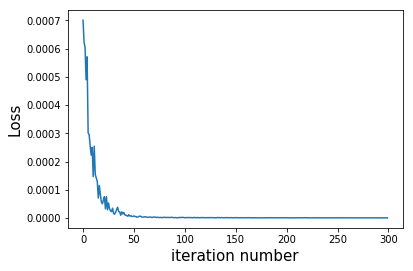

In [8]:
# Plot loss
plt.plot(dg.loss[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss', fontdict={'fontsize': 15})
plt.show()

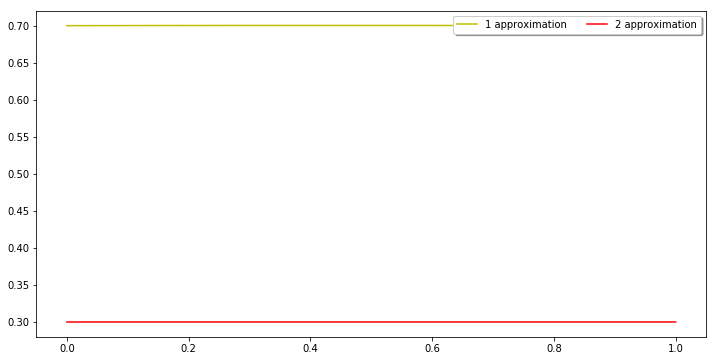

In [9]:
# Plot true solutions and their approximations
n_el = 100
fig, ax = plt.subplots(figsize=(12, 6))
pts_ = np.linspace(0, 1, n_el).reshape((n_el, 1))
pts = np.asarray([[0.5, 0.5, point, 0.1] for point in pts_])

approxs_1 = dg.solve(pts)[:, 0]
approxs_2 = dg.solve(pts)[:, 1]

# plt.plot(pts, true_sin, 'g--', linewidth=3, label='true sin')
plt.plot(pts_, approxs_1.reshape(n_el, ), 'y', label='1 approximation')
# plt.plot(pts, true_cos, 'b--',  linewidth=3, label='true cos')
plt.plot(pts_, approxs_2.reshape(n_el, ), 'r', label='2 approximation')

plt.legend(loc='upper right', shadow=True, ncol=2)
fig.show()